In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as sio
import glob
import os
import h5py
from sklearn.cluster import KMeans
from warnings import warn


def load_spike_file(path):
    """
    Loads spikes file from specified path
    """
    mat  = h5py.File(path)
    spks = mat['spikes']
    assigns     = np.asarray(spks['assigns']).T        # ndarray shape(n) n: num of spike times for all units
    trials      = np.asarray(spks['trials']).T         # ndarray shape(n) n: num of spike times for all units
    spike_times = np.asarray(spks['spiketimes']).T     # ndarray shape(n) n: num of spike times for all units
    waves       = np.asarray(spks['waveforms']).T      # ndarray shape(n x m x p) n: num of spike times for all units m: num of range(m)les in waveform
    trial_times = np.asarray(spks['trial_times']).T    # p: num of recording channels
    labels      = np.asarray(spks['labels']).T
    unwrapped   = np.asarray(spks['unwrapped_times']).T
    nsamp       = waves.shape[1]
    nchan       = waves.shape[2]  # get number of channels used

    uniqassigns = np.unique(assigns)  # get unique unit numbers
    unit_type   = labels[:, 1]        # get unit type 0=noise, 1=multi-unit, 2=single-unit, 3=unsorted
    ids         = labels[:, 0]
    nunit       = len(ids)

    return labels, assigns, trials, spike_times, waves, nsamp, nchan, ids, nunit, unit_type, trial_times, unwrapped

In [2]:
# find all spikes files in the current directory and all directories bellow
spike_files = list()
for (dirpath, dirnames, filenames) in os.walk('.'):
    glob_list = glob.glob(dirpath + os.path.sep + '*spikes.mat')
    if glob_list:
        spike_files.extend(glob_list)

spike_files = sorted(spike_files)
print(spike_files)

labels, assigns, trials, spike_times, waves, nsamp, nchan, ids, nunit,\
unit_type, trial_times, unwrapped = load_spike_file(spike_files[1])

['./FID1302-e1-spikes.mat', './e2/FID1302-e2-spikes.mat']


## Spike rate for entire experiment

In [3]:
%matplotlib notebook
gu_inds   = np.where(np.logical_and(labels[:, 1] > 0, labels[:, 1] < 3) == True)[0]
gu_ids    = labels[gu_inds, 0]
binsize   = 1

uind = 5

spk_times = unwrapped[np.where(assigns == gu_ids[uind])[0]]/60
bins      = np.arange(0, unwrapped[-1]/60.0, binsize)
counts, pltbins = np.histogram(spk_times, bins=bins)
plt.bar(pltbins[:-1], counts/60.0, width=1.0, facecolor='black', edgecolor='black')
plt.ylabel('firing rate (Hz)')
plt.xlabel('time (min)')


/Users/Greg/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>

## autocorrelogram

In [4]:
binsize = 0.002 #seconds
num_samples = 1000
spk_times = unwrapped[np.where(assigns == gu_ids[uind])[0]]
xt = spk_times
bins = np.arange(-0.5, 0.5, binsize)
bin0_ind = np.logical_and(bins >= -binsize, bins <= binsize)

counts = np.zeros(bins.shape[0]-1)
counts.shape
xt_sample = np.random.choice(np.ravel(xt), size=num_samples, replace=False, p=None)
for x in xt_sample:
#     spk_times_temp = xt[np.logical_and(xt >= (x + bins[0]), xt <= (x + bins[-1]))]
    counts += np.histogram(xt, bins + x)[0]
#     counts += np.histogram(yt, bins+x)[0]
plt.figure()
counts[bin0_ind,] = 0
plt.bar(bins[:-1], counts/num_samples, width=binsize, facecolor='black', edgecolor='black')
plt.xlim(-0.5, 0.5)
plt.show()

<IPython.core.display.Javascript object>

/Users/Greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 499 but corresponding boolean dimension is 500


## ISI distribution

<IPython.core.display.Javascript object>


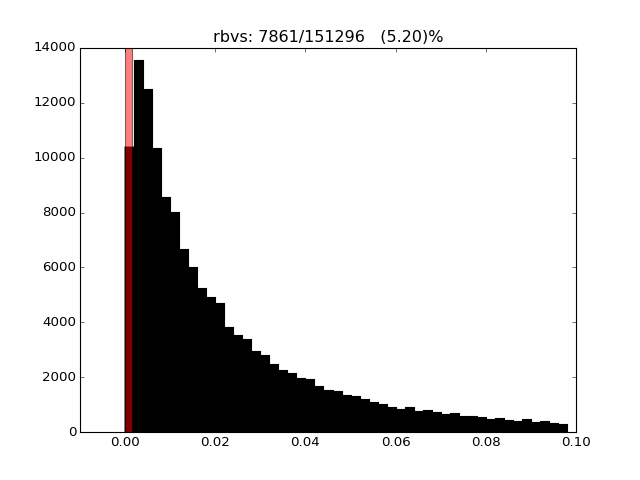

In [6]:
from matplotlib.patches import Rectangle
isi = np.diff(np.ravel(spk_times))
rpv = np.sum(isi <= 0.0015)
binsize = 0.002 #seconds
bins = np.arange(0, 0.100, binsize)
counts = np.histogram(0, bins + x)[0]

plt.figure()
plt.hist(isi, bins=bins, facecolor='black', edgecolor='black')
# plt.bar(bins[:-1], counts/num_samples, width=binsize, facecolor='black', edgecolor='black')
plt.xlim(-0.01, 0.1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, 0), 0.0015, plt.ylim()[1], facecolor="red", alpha=0.5))
plt.show()

plt.title('rbvs: ' + str(rpv) + '/' + str(len(isi)) + '   ({:2.2f})%'.format(rpv/float(len(isi))*100))


## cross-correlogram

<IPython.core.display.Javascript object>


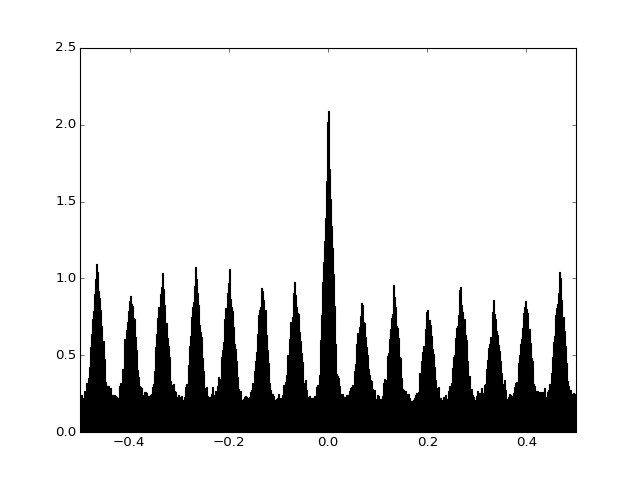

In [7]:
spk_times01 = unwrapped[np.where(assigns == gu_ids[3])[0]]/60
spk_times02 = unwrapped[np.where(assigns == gu_ids[6])[0]]/60

binsize = 0.002 #seconds
num_samples = 1000
xt = spk_times01
yt = spk_times02
bins = np.arange(-0.5, 0.5, binsize)
counts = np.zeros(bins.shape[0]-1)
counts.shape
xt_sample = np.random.choice(np.ravel(xt), size=num_samples, replace=False, p=None)
for x in xt_sample:
    counts += np.histogram(yt, bins + x)[0]
plt.figure()
plt.bar(bins[:-1], counts/num_samples, width=binsize, facecolor='black', edgecolor='black')
plt.xlim(-0.5, 0.5)
plt.show()

<IPython.core.display.Javascript object>


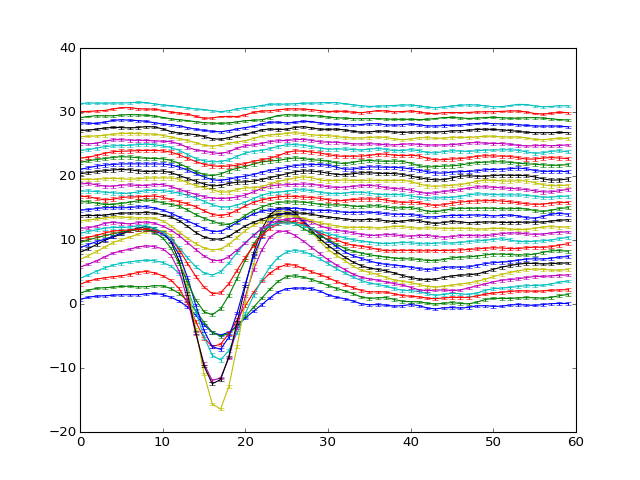

In [34]:
# wave_inds   = np.random.choice(np.ravel(np.where(assigns == gu_ids[uind])[0]), size=num_samples, replace=False, p=None)
# wave_select = waves[wave_inds, :, :]
# mean_wave   = np.mean(wave_select, axis=0)
# semm_wave   = sp.stats.sem(wave_select, axis=0)

x = np.arange(0, mean_wave.shape[0])
y = mean_wave
yerr = semm_wave
offset = np.arange(0, mean_wave.shape[0])

plt.figure()
for site in range(32):
    plt.errorbar(x, y[:,site]+offset[site], yerr[:,site])
#     plt.fill_betweenx(np.arange(60), y[:,site]+offset[site]-yerr[:,site], y[:,site]+offset+yerr[:,site], alpha=0.5)
plt.show()